# TP Vectorisation et ensemble de Julia

In [8]:
from IPython.display import HTML
HTML(url="https://deptinfo-ensip.univ-poitiers.fr/FILES/NB/files/nb2.css")

In [9]:
# Modules utilisés dans la suite 
import random
import time
import matplotlib.pyplot as plt
import numpy as np
# Quelques réglages 
plt.rcParams['figure.dpi'] = 150 # Figures un peu plus grandes que le défaut
np.set_printoptions(precision=3) # Pour n'afficher que 3 chiffres après la virgule
np.random.seed(1) # reproducibilité des résultats

Nous proposons ici de tracer des ensembles de Julia en noir et blanc,
puis en couleur. Dans un premier temps nous ferons un calcul non
optimisé pour la vitesse, puis nous verrons comment *vectoriser* le
calcul en utilisant `numpy`


## Références

- [Ensemble de Julia sur Wikipedia](https://fr.wikipedia.org/wiki/Ensemble_de_Julia)
- [Cartographie de l'ensemble de Julia sur Wikipedia](http://commons.wikimedia.org/wiki/Image:Julia-Teppich.png)
- [Une documentation assez technique](http://john.bonobo.free.fr/fractal/doc.php)
- [Démonstration de la propriété de convergence](https://deptinfo-ensip.univ-poitiers.fr/FILES/PDF/demo_fractales.pdf)

## Version monochrome

### Rappels sur les ensembles de Julia

Notons tout d'abord qu'il existe plusieurs ensembles de Julia. Pour
chaque nombre complexe $c$ choisi, il y a un ensemble. Nous noterons
$J(c)$ l\'ensemble des points du plan appartenant à l'ensemble de
Julia paramétré par $c$.


> L'ensemble de Julia $J(c)$ étant un ensemble de points
du plan, nous pouvons le voir comme un ensemble de nombres complexes.
Les nombres complexes appartenant à $J(c)$ sont les nombres $u_0$
tels que la suite : $$\forall n>0, u_n=u_{n-1}^2+c$$ a un
module qui reste fini.

Dans un premier temps, nous tracerons l'ensemble de Julia correspondant
à $c=-0.85 + 0.2 i$. Il faut que cette valeur soit facile à modifier
par la suite : gardez ceci à l'esprit tout au long de la construction
du programme (car nous testerons d'autres valeurs).

On ne peut pas déterminer sur une machine si les termes de la suite
précédente ont un module qui reste fini ou non en calculant simplement
un grand nombre de termes. Il faudra donc faire quelques concessions à
l'exactitude. Une bonne approximation consiste à calculer les 200
premiers termes de la suite et à utiliser cette propriété (valable si le
module de c est strictement inférieur à 2) :

> S'il existe $N$, entier, tel que le module de $u_N$
soit strictement plus grand que 2, alors la suite n'a pas un module qui
reste fini.

Ainsi, si nous trouvons un terme de module supérieur à deux, nous
pourrons conclure que le point n'est pas dans l'ensemble de Julia. Si
au bout du 100e terme, aucun n'a dépassé 2 en module, on conclura
(parfois faussement) que le point est dans l'ensemble de Julia.

### Première fonction

En vous aidant des indications données précédement, et de la manière de
manipuler les nombres complexes en Python (cherches dans la documentation officielle), écrivez une fonction
`julia(u0,c)` qui indique en renvoyant 0 ou 1 si `u0` est dans `J(c)`.

Vous utiliserez un paramètre supplémenatire ayant une valeur par défaut (N = 200), pour stopper les itérations.


In [10]:
def julia(u0: complex, c: complex, N=200) -> int: 
    """
    Indique si le complexe u0 appartient (1) 
    ou non (0) à J(c) 
    """
    assert abs(c) < 2
    for _ in range(N):
        if abs(u0) > 2:
            return False
        u0 = u0**2 + c
    return True

Vous devez maintenant tester votre fonction.
Écrivez des assertions (`assert`) qui vérifient que vos résultats sont conformes à ceux énoncés ci dessous :

Pour $c=-0.85+0.2i$ :

-   les 3 points : 0, 0.3j et 1 sont dans l'ensemble de Julia
-   les 2 points 0.3 et 1+j ne sont pas dans l'ensemble de Julia

In [11]:
# Entrez vos assertions ici
c = complex(-0.85, 0.2)
j = complex(-0.5, np.sqrt(3)/2)
a1, a2, a3 = 0, 0.3*j, 1
b1, b2 = 0.3, 1+j
assert julia(a1, c) and julia(a2, c) and julia(a3, c)
assert not julia(b1, c) and not julia(b2, c)

### Représentation de l'image

La première chose à décider est le nombre de points que nous allons
calculer. Restons modestes dans un premier temps, et calculons 400x400
pixels. Les valeurs de ces pixels (1 ou 0 selon qu'on est ou pas dans
l'ensemble de Julia) seront stockés dans une matrice `numpy` :

In [12]:
image = np.zeros((400,400), dtype=np.uint8)

Pour tester l'affichage, nous allons mettre aléatoirement quelques
pixels à 1 dans cette image :

In [13]:
for i in range(400*400 // 4):
    x = random.randint(0, 399)
    y = random.randint(0, 399)
    image[x, y] = 1

Puis nous l'affichons avec matplotlib :

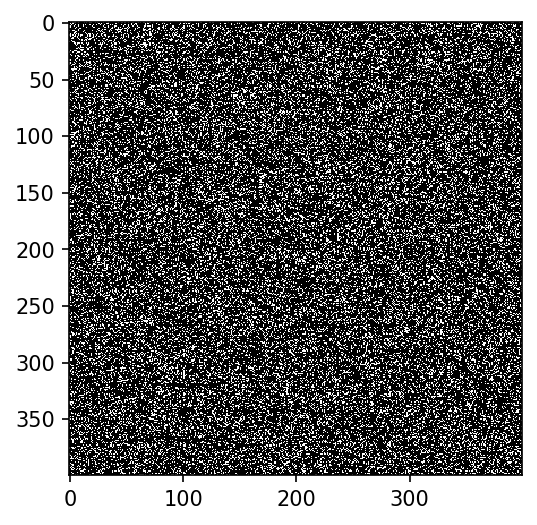

In [14]:
plt.imshow(image, cmap=plt.get_cmap('gray'), interpolation='nearest', vmin=0.0, vmax=1.0, aspect='equal')
plt.show()

La fonction `imshow` permet :

-   de choisir une carte de couleurs (la liste est ici : [Matplotlib
    Colormaps](http://matplotlib.org/users/colormaps.html))
-   de **ne pas** interpoler entre les pixels (avec `nearest`, sans
    cette option, il y aura de l'interpolation)
-   de préciser les valeurs min et max de l'image et leur
    correspondance dans la colormap. Si on ne précise pas, `imshow` fait
    correspondre la valeur max de l'image à la valeur max de la
    colormap (idem pour la valeur min).

### Changement de repère

Ce qui précède nous permet, étant donné un nombre complexe $u_0$, de
savoir s'il est ou non dans l'ensemble de Julia. De plus, nous savons
représenter une matrice de valeurs (dont les coordonnées sont entières)
à l'écran. Il reste maintenant à faire correspondre les nombres
complexes manipulés aux coordonnées des valeurs dans la matrice numpy.

Ceci s'apparente à un simple changement de repère. Nous devons décider
quelles sont les limites (parties réelles et imaginaires) de $u_0$,
et en déduire le changement de repère (mise à l'échelle et
translation).

> En admettant que nous désirions tracer l'ensemble de
Julia pour $u_0=a+ib$ avec $-2\le a\le 1$ et $-1.5\le b\le 1.5$, 
dans une matrice de taille 200x200 (les coordonnées vont donc de 0 à 199), le changement de repère
adéquat est :

$$\left\{\begin{array}{l}a=\frac{j}{199}\times3-2\\
b=\frac{i}{199}\times3-1.5\end{array}\right.$$

Vérifiez (par le calcul ou mentalement) que le point (0,0) est bien
envoyé sur (-2,-1.5) (les valeurs mini pour $a$ et $b$) et que le point
(199,199) (situé hors de la matrice) est envoyé sur (1,1.5) (les valeurs maxi pour $a$ et $b$).

Les données de cadrage peuvent être groupées dans un dictionnaire. Par exemple, pour le cadrage ci-dessus :

~~~python
cadrage = {'xmin': -2, 'xmax': 1, 'ymin': -1.5, 'ymax': 1.5, 'width': 200, 'height': 200}
~~~

Vous devez écrire la fonction `conversion` qui prendra en paramètre des coodonnées dans la matrice image (ligne `i` et colonne `j`) les données de cadrage (un dictionnaire) et renvoie le complexe associé.

In [17]:
def conversion(i: int, j: int, cadrage: dict) -> complex:
    a = (cadrage['xmax'] - cadrage['xmin']) * j / (cadrage['width']  - 1)+ cadrage['xmin']
    b = (cadrage['ymax'] - cadrage['ymin']) * i / (cadrage['height'] - 1) + cadrage['ymin']
    return complex(a, b)

Définissez un dictionnaire de cadrage de manière à pouvoir produire une image 400x400, telle que : $-1.25\le a\le 1.25$ et
$-1.25\le b\le 1.25$.

In [21]:
cadrage        = {'xmin': -2, 'xmax': 1, 'ymin': -1.5, 'ymax': 1.5, 'width': 200, 'height': 200}
cadrage_defaut = {'xmin': -1.25, 'xmax': 1.25, 'ymin': -1.25, 'ymax': 1.25, 'width': 400, 'height': 400}

Vérifiez que votre fonction `conversion` est correcte (pour
des entrées dont vous pouvez facilement calculer la sortie...). Entrez vos
assertions ci-dessous :

In [27]:
assert conversion(0, 0, cadrage_defaut)     == complex(-1.25, -1.25)
assert conversion(399, 399, cadrage_defaut) == complex(1.25, 1.25)
assert conversion(0, 0, cadrage)            == complex(-2, -1.5)
assert conversion(199, 199, cadrage)        == complex(1, 1.5)

### Tracé et programme principal

Nous savons maintenant faire les choses suivantes :

- associer un nombre complexe $u_0$ à des coordonnées (i,j) de pixels sur l'écran : fonction ''conversion'', prenant en paramètres deux entiers et renvoyant un nombre complexe
- décider si un nombre complexe $u_0$ appartient à $J(c)$ ou pas : fonction ''julia'' prenant en paramètres deux complexes $u_0$ et $c$ et décidant si $u_0$ appartient à $J(c)$ ou non. Cette fonction renvoie un 0 ou 1.

Nous pouvons maintenant proposer un algorithme pour le calcul de
l'image, qui crée une matrice en prenant en paramètre la valeur de c
(paramètre de l'ensemble de Julia) :

    def calcul_img(c, cadrage) 
    |  img <- création de la matrice à la bonne taille
    |  Pour chaque coordonnée (i,j) de la matrice :
    |  | u <- conversion(i,j, cadrage) 
    |  | img[i,j] <- julia(u,c) 
    |  retourner img

Attention à la boucle de calcul qui en cache en fait 2 : une pour les
abscisses et une pour les ordonnées.

Le programme principal, se résumera donc à :

    c   <- -0.85+0.2i
    cadrage = {...}
    img <- calcul_img(c, cadrage)
    afficher l'image avec imshow

Il reste à écrire la fonction `calcul_img` et à tester le programme.
Vous devriez obtenir une image similaire à celle-ci (attention, le blanc et le noir sont inversés) : ![Ensemble de
Julia](https://deptinfo-ensip.univ-poitiers.fr/ENS/doku/lib/exe/fetch.php/tp:python:julia_nb.png)

In [28]:
def calcul_img(c: complex, cadrage: dict) -> np.ndarray:
    image = np.zeros((cadrage['width'], cadrage['height']), dtype=np.uint8)
    for j in range(cadrage['width']):
        for i in range(cadrage['height']):
            u = conversion(i,j, cadrage)
            image[i,j] = julia(u, c)     
    return image

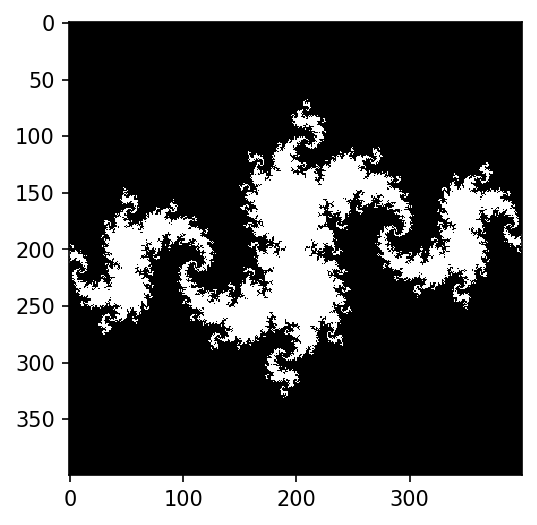

In [29]:
c = complex(-0.85, 0.2)
img = calcul_img(c, cadrage_defaut)
plt.imshow(img, cmap=plt.get_cmap('gray'), interpolation='nearest', vmin=0.0, vmax=1.0, aspect='equal')
plt.show()

## Version en couleur

Nous allons maintenant essayer d'obtenir des images en couleur,
modifier la valeur de $c$ et modifier éventuellement le cadrage.

### Obtenir de la couleur

Le principe est simple: la fonction `julia` renvoyait jusqu'à présent 0
ou 1, ce qui correspond aux deux couleurs utilisées. Nous allons donc
écrire une nouvelle fonction `julia_couleur` de telle manière qu'elle puisse renvoyer
un plus grand nombre de valeurs différentes.

Considérez le fait suivant : Pour un point donné $u_0$ qui conduit à
une suite dont le module ne reste pas fini, nous nous en apercevons si
le module d'un terme de la suite dépasse 2. Mais nous pouvons nous en
apercevoir dans les premiers termes ou au contraire au bout du centième
etc... Nous pouvons donc savoir si une suite a rapidement eu un terme
dont le module dépasse 2. Autrement dit, ce qui nous intéresse
lorsqu'un terme $u_i$ de la suite a un module qui dépasse 2, c'est
: combien vaut $i$ à ce moment là ?

En vous inspirant de la fonction `julia` déjà réalisée, écrivez une nouvelle fonction `julia_couleur` qui réalise ceci :

- si au bout de 100 termes, tous les modules sont restés inférieurs à 2, elle renvoie la valeur 0
- si lors du calcul du terme numéro i, le module dépasse 2, la fonction renvoie un nombre **strictement positif** (peut être i ou i+1...)

In [40]:
def julia_couleur(u0: complex, c: complex, N=200) -> int:
    """
    Indice du premier terme de la suite dont le module > 2 ; 
    Retourne 0 si cela n'arrive pas jusqu'au 100e.
    """
    assert abs(c) < 2
    for n in range(N):
        if abs(u0) > 2:
            return n+1
        u0 = u0**2 + c
    return 0

Nous disposons maintenant d'une fonction `julia_couleur` qui renvoie 0 si le
point est dans l'ensemble, et qui renvoie un entier **strictement**
positif sinon.

Réécrivez une fonction `calcul_img_couleur`, similaire à `calcul_img`, mais qui utilise `julia_couleur`. Puis, en jouant sur la colormap et les valeurs `vmin`, `vmax` de
`imshow`, produisez une image couleur de l'ensemble de Julia.

Voici un exemple d\'image obtenue par ce principe :

![](https://deptinfo-ensip.univ-poitiers.fr/ENS/doku/lib/exe/fetch.php/tp:python:lsignac_juliaimg.png)

L'utilisation des colormap nous épargne le calcul
qui permet de fabriquer les couleurs à partir d'un nombre unique et la
manière dont elles se succèdent dans le dégradé. Ce serait une part
importante du travail si `matplotlib` ne contenait pas déjà certaines
fonctionnalités.

In [31]:
def calcul_img_couleur(c: complex, cadrage: dict) -> np.ndarray:
    image = np.zeros((cadrage['width'], cadrage['height']), dtype=np.uint8)
    for j in range(cadrage['width']):
        for i in range(cadrage['height']):
            u = conversion(i,j, cadrage)
            image[i,j] = julia_couleur(u, c)     
    return image

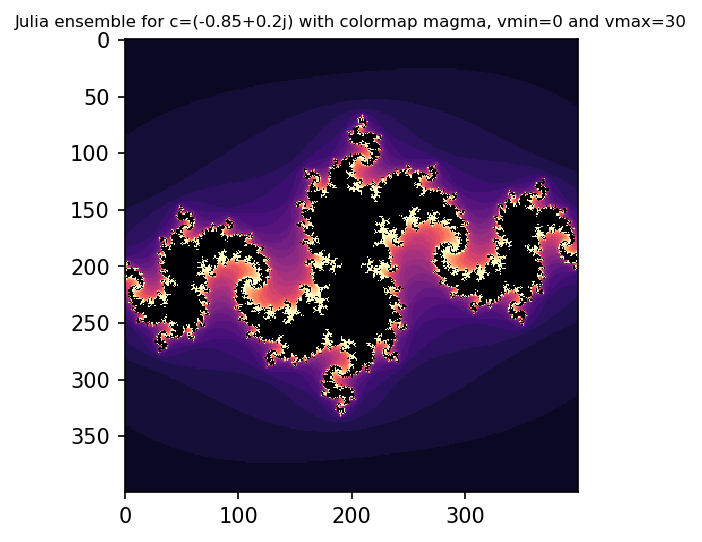

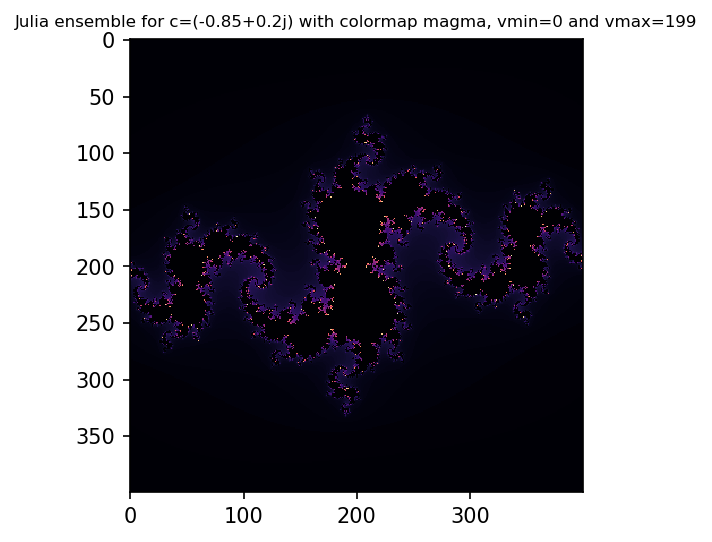

In [80]:
# Réalisez vos tracés ci-dessous :
def build_image(cmap, c=complex(-0.85, 0.2), mode='parametric', vmin=0, vmax=200):
    img = calcul_img_couleur(c, cadrage_defaut)
    if mode == 'auto':
        vmin, vmax = img.min(), img.max()
    plt.imshow(img, cmap=plt.get_cmap(cmap), interpolation='nearest', vmin=vmin, vmax=vmax, aspect='equal')
    c2 = complex(round(c.real,2), round(c.imag, 2))
    plt.title(f'Julia ensemble for c={c2} with colormap {cmap}, vmin={vmin} and vmax={vmax}', fontsize=8)
    plt.show()
build_image(cmap='magma', vmax=30)
build_image(cmap='magma', mode='auto')

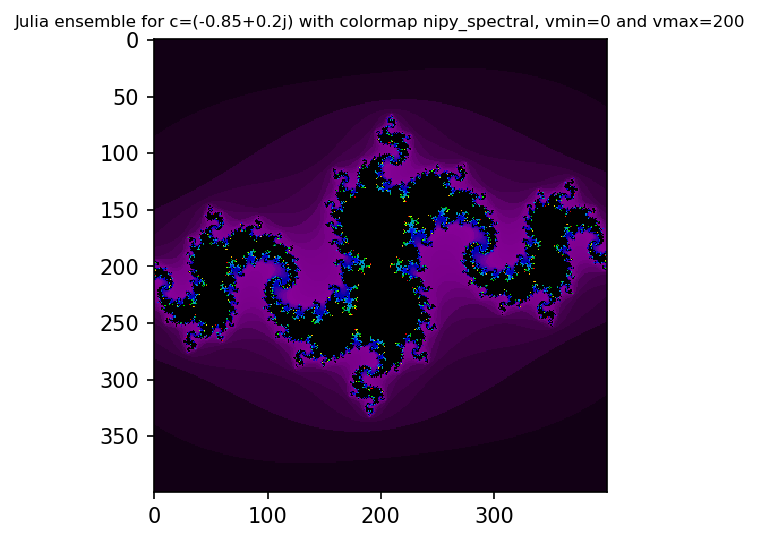

In [83]:
build_image('nipy_spectral')

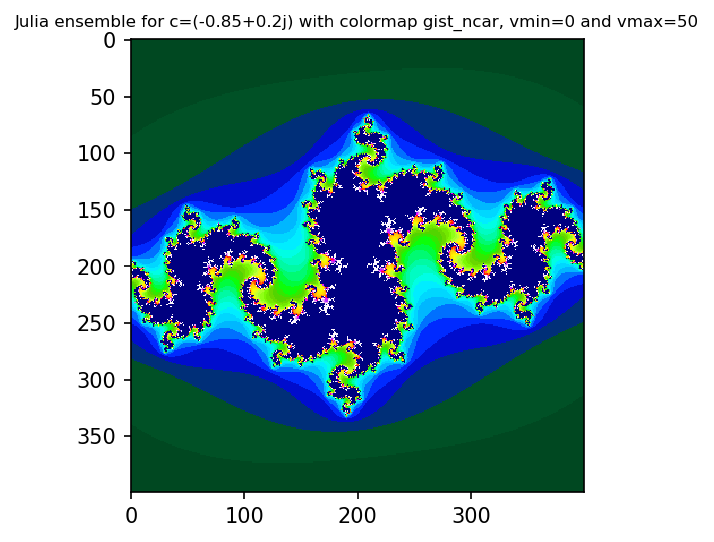

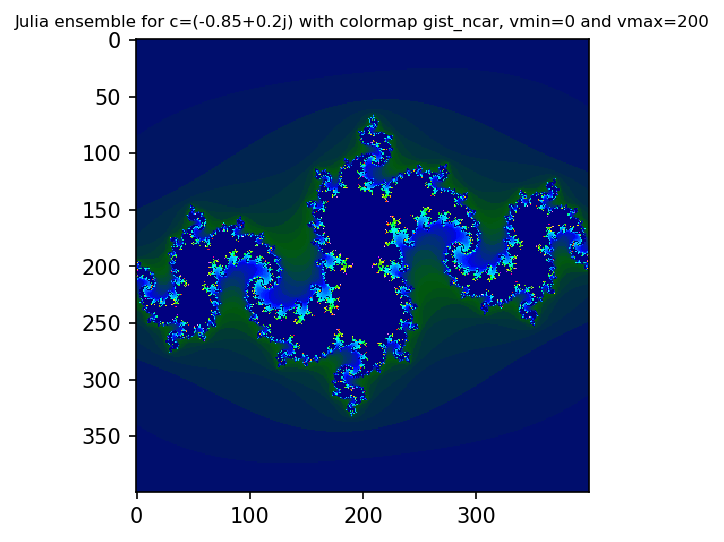

In [82]:
build_image('gist_ncar', vmax=50)
build_image('gist_ncar')

### Modification de la valeur de c

Nous avons fixé une valeur de $c$ de manière arbitraire. Vous pouvez
changer cette valeur pour obtenir d\'autres images (aidez vous de la
cartographie de l\'ensemble de Julia indiquée en début de sujet).

### Modification du cadrage

Nous avons fixé les bornes de tracé de l'ensemble de Julia à -1.25,
1.25 en abscisse et en ordonnées. Vous pouvez modifier ces bornes pour
obtenir un «zoom» sur certaines parties de l'image.

### Résultats obtenus

Voici quelques échantillons de résultats possible.

| ![](https://deptinfo-ensip.univ-poitiers.fr/ENS/doku/lib/exe/fetch.php/tp:python:julia1.png) | ![](https://deptinfo-ensip.univ-poitiers.fr/ENS/doku/lib/exe/fetch.php/tp:python:julia2.png) |
|-------|------------|
|![](https://deptinfo-ensip.univ-poitiers.fr/ENS/doku/lib/exe/fetch.php/tp:python:julia3.png) |![](https://deptinfo-ensip.univ-poitiers.fr/ENS/doku/lib/exe/fetch.php/tp:python:julia4.png)|

Essayez d'obtenir une belle image, avec une colormap de
votre choix, votre propre valeur de $c$ et un cadrage éventuellement
différent de celui proposé en début de TP. 

Ne mettez pas n'importe quoi
pour les paramètres `vmin` et `vmax` de `imshow`. Essayez de comprendre
à quoi ils correspondent.

In [101]:
#D'abord, on construit une fonction pour obtenir un c complexe quelconque de module < 2
from numpy.random import RandomState
def get_random_c(random_state=None):
    prng = RandomState(random_state)
    return 2*prng.random()*np.exp(complex(0, 2*np.pi*prng.random()))
get_random_c()

(0.3599616610423093-1.8681279737581562j)

In [86]:
#On a besoin d'une fonction pour modifier facilement le cadrage par défaut
def modify_cadrage_defaut(**kwargs):
    global cadrage_defaut
    for key, val in kwargs.items():
        cadrage_defaut[key] = val
modify_cadrage_defaut(xmin=-0.5, xmax=0.5, ymin=-1, ymax=0)
cadrage_defaut

{'xmin': -0.5, 'xmax': 0.5, 'ymin': -1, 'ymax': 0, 'width': 400, 'height': 400}

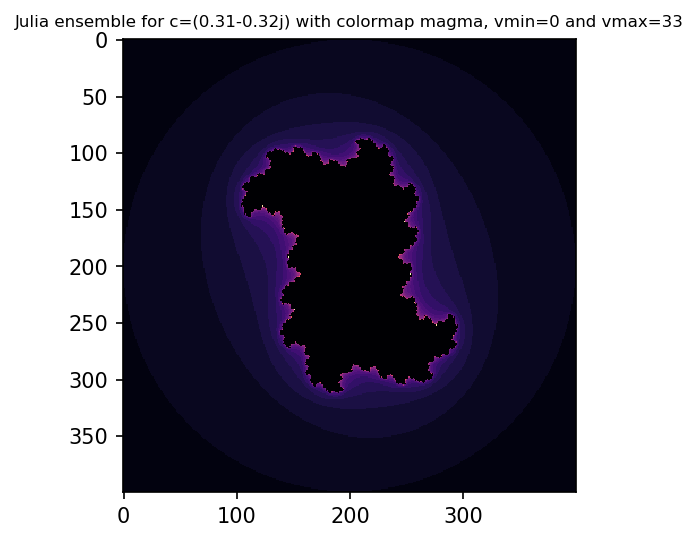

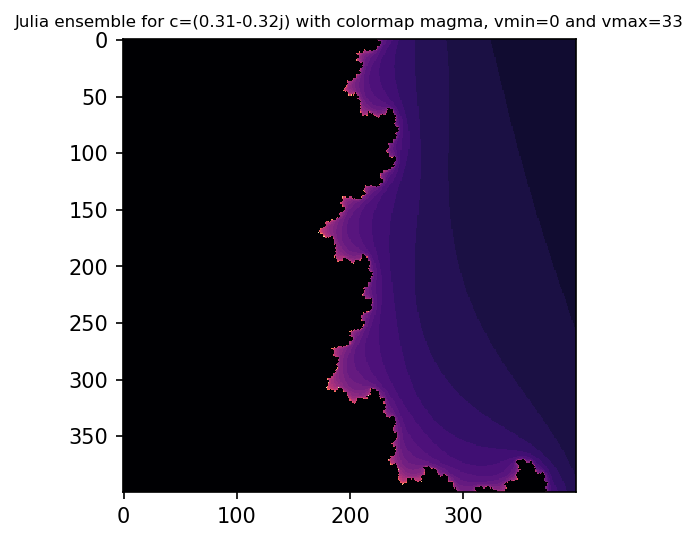

In [128]:
modify_cadrage_defaut(xmin=-2, xmax=2, ymin=-2, ymax=2)
build_image(cmap='magma', mode='auto', c=get_random_c(5))
modify_cadrage_defaut(xmin=0, xmax=1, ymin=-0.5, ymax=0.5)
build_image(cmap='magma', vmin=0, vmax=33, c=get_random_c(5))

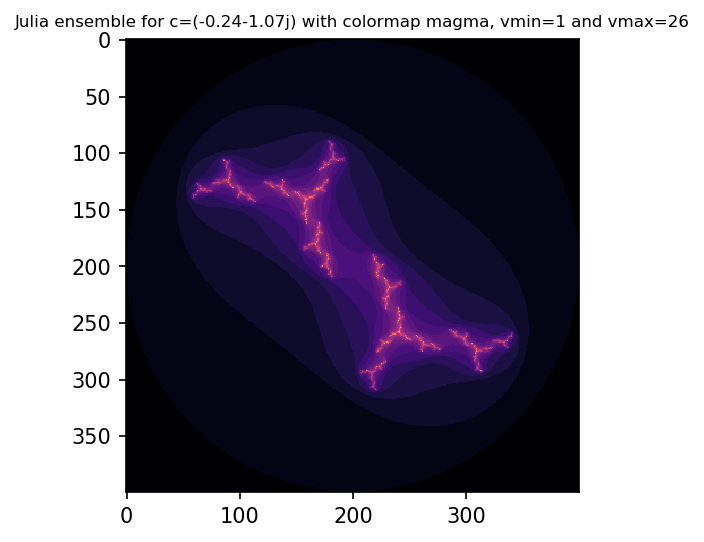

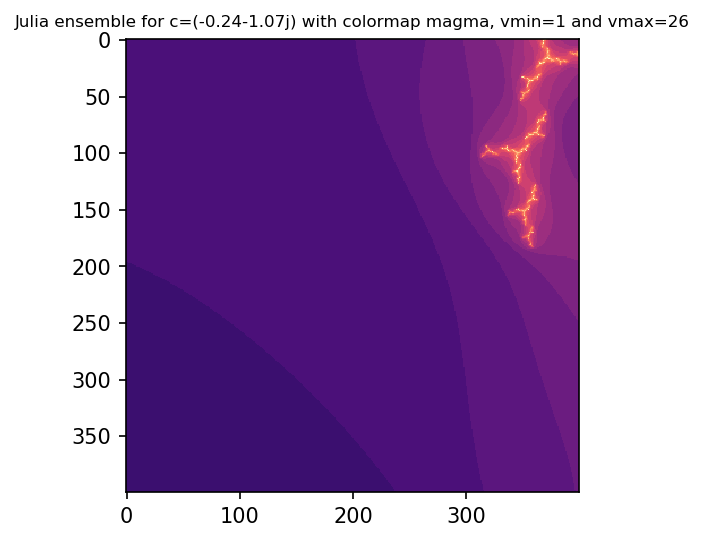

In [125]:
modify_cadrage_defaut(xmin=-2, xmax=2, ymin=-2, ymax=2)
build_image(cmap='magma', mode='auto', c=get_random_c(0))
modify_cadrage_defaut(xmin=0, xmax=0.25, ymin=0, ymax=0.25)
build_image(cmap='magma', vmin=1, vmax=26, c=get_random_c(0))

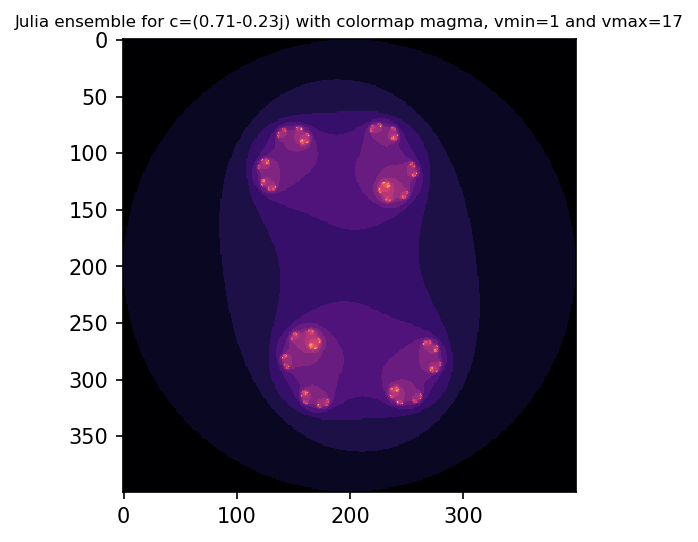

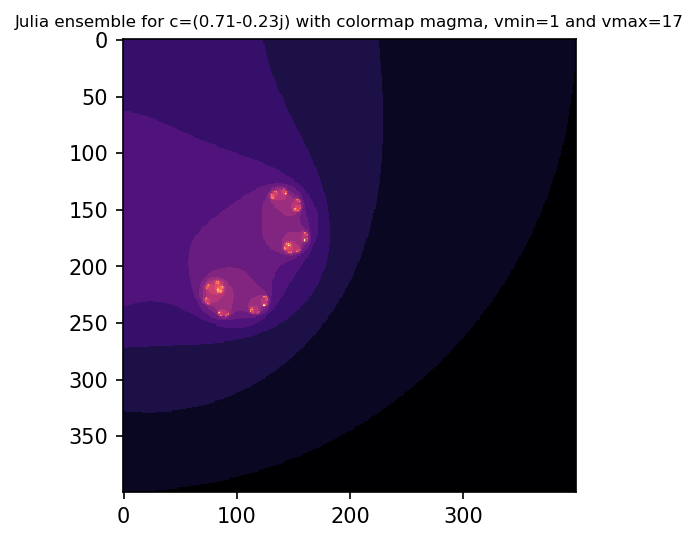

In [127]:
modify_cadrage_defaut(xmin=-2, xmax=2, ymin=-2, ymax=2)
build_image(cmap='magma', mode='auto', c=get_random_c(42))
modify_cadrage_defaut(xmin=0, xmax=2, ymin=0, ymax=2)
build_image(cmap='magma', vmin=1, vmax=17, c=get_random_c(42))

## Optimisation du calcul

Comme vous l'avez remarqué, le calcul n'est pas très rapide. Si nous
voulions obtenir une image de taille conséquente... ça pourrait être assez long.

Pour accélérer le calcul, nous allons utiliser le principe de la
*vectorisation*. En effet, les mêmes calculs sont menés sur chaque pixel
de l'image. Utiliser la vectorisation consiste à fournir l'ensemble
des points sur lesquels faire le calcul et `numpy` les fera *en
parallèle* (ils sont faits en parallèle du point de vue de
l'utilisateur, mais la machine, finalement, les fait séquentiellement,
par contre toutes les optimisations possibles sont utilisées (raccourcis
de calcul, utilisation de bibliothèques déjà compilées,...).

**L'idée générale est de fournir une matrice contenant toutes les valeurs
de $u_0$ pour lesquels on veut faire le calcul. Si cette matrice s'appelle `mat_u`
le calcul se limitera à : `mat_u <- mat_u ** 2 + C` (et les boucles, 
lentes en Python, seront supprimées).**

Voici les différentes étapes illustrées par une petite matrice 5x5.

> Il est probable que ce qui suit soit nouveau pour vous,
lisez attentivement et testez les exemples. Assurez-vous de les
comprendre parfaitement.

Le premier objectif est d'obtenir la matrice de départ. Chaque case
correspond à un pixel de l'image et contient la valeur de $u_0$
utilisée pour ce pixel :

    [[-1.250-1.25j  -0.625-1.25j   0.000-1.25j   0.625-1.25j   1.250-1.25j ]
     [-1.250-0.625j -0.625-0.625j  0.000-0.625j  0.625-0.625j  1.250-0.625j]
     [-1.250+0.j    -0.625+0.j     0.000+0.j     0.625+0.j     1.250+0.j   ]
     [-1.250+0.625j -0.625+0.625j  0.000+0.625j  0.625+0.625j  1.250+0.625j]
     [-1.250+1.25j  -0.625+1.25j   0.000+1.25j   0.625+1.25j   1.250+1]]

Cette matrice est une combinaison de ces deux matrices :

    [[-1.25  -0.625  0.     0.625  1.25 ]
     [-1.25  -0.625  0.     0.625  1.25 ]
     [-1.25  -0.625  0.     0.625  1.25 ]
     [-1.25  -0.625  0.     0.625  1.25 ]
     [-1.25  -0.625  0.     0.625  1.25 ]]

et 

    [[-1.25  -1.25  -1.25  -1.25  -1.25 ]
     [-0.625 -0.625 -0.625 -0.625 -0.625]
     [ 0.     0.     0.     0.     0.   ]
     [ 0.625  0.625  0.625  0.625  0.625]
     [ 1.25   1.25   1.25   1.25   1.25 ]]


Chacune de ces deux matrices est obtenue en faisant le produit (`np.dot`) entre une matrice ligne et une matrice colonne.

Par exemple :


                                                     | -1.25  -0.625  0.     0.625  1.25 |
                                                 X
                                                 
    [[-1.25  -0.625  0.     0.625  1.25 ]     | 1. |
     [-1.25  -0.625  0.     0.625  1.25 ]     | 1. |
     [-1.25  -0.625  0.     0.625  1.25 ]  =  | 1. |
     [-1.25  -0.625  0.     0.625  1.25 ]     | 1. |
     [-1.25  -0.625  0.     0.625  1.25 ]]    | 1. |


Les matrices lignes et colonnes, en question peuvent être obtenues à partir de vecteurs, en utilisant la méthode `reshape`.
Et les deux vecteurs eux-même peuvent être obtenus avec les fonctions `np.ones` et `np.linspace`.

Essayez d'obtenir cette matrice en utilisant les opérations proposées (ou autrement si vous connaissez un autre moyen (il y en a)).

In [138]:
size = 5
ligne = np.linspace(-size/(size-1), size/(size-1), size).reshape((size,1))
colonne = np.ones((1,size))
matrice_a = np.outer(colonne, ligne)
matrice_b = matrice_a.transpose()
print('Matrice réelle :\n',matrice_a, '\nMatrice imaginaire :\n', matrice_b)
mat_u = matrice_a + 1j * matrice_b
print('Matrice complexe :\n',mat_u)

Matrice réelle :
 [[-1.25  -0.625  0.     0.625  1.25 ]
 [-1.25  -0.625  0.     0.625  1.25 ]
 [-1.25  -0.625  0.     0.625  1.25 ]
 [-1.25  -0.625  0.     0.625  1.25 ]
 [-1.25  -0.625  0.     0.625  1.25 ]] 
Matrice imaginaire :
 [[-1.25  -1.25  -1.25  -1.25  -1.25 ]
 [-0.625 -0.625 -0.625 -0.625 -0.625]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.625  0.625  0.625  0.625  0.625]
 [ 1.25   1.25   1.25   1.25   1.25 ]]
Matrice complexe :
 [[-1.25 -1.25j  -0.625-1.25j   0.   -1.25j   0.625-1.25j   1.25 -1.25j ]
 [-1.25 -0.625j -0.625-0.625j  0.   -0.625j  0.625-0.625j  1.25 -0.625j]
 [-1.25 +0.j    -0.625+0.j     0.   +0.j     0.625+0.j     1.25 +0.j   ]
 [-1.25 +0.625j -0.625+0.625j  0.   +0.625j  0.625+0.625j  1.25 +0.625j]
 [-1.25 +1.25j  -0.625+1.25j   0.   +1.25j   0.625+1.25j   1.25 +1.25j ]]


Une fois cette matrice obtenue, nous
pouvons réaliser une itération sur toutes les valeurs de la matrice
ainsi;

    mat_u = mat_u ** 2 + c
    print(mat_u)

    [[-0.850+3.325j -2.022+1.762j -2.413+0.2j   -2.022-1.363j -0.850-2.925j]
     [ 0.322+1.762j -0.850+0.981j -1.241+0.2j   -0.850-0.581j  0.322-1.363j]
     [ 0.713+0.2j   -0.459+0.2j   -0.850+0.2j   -0.459+0.2j    0.713+0.2j  ]
     [ 0.322-1.363j -0.850-0.581j -1.241+0.2j   -0.850+0.981j  0.322+1.762j]
     [-0.850-2.925j -2.022-1.363j -2.413+0.2j   -2.022+1.762j -0.850+3.325j]]

Dans ce qui précède, si c est un scalaire (complexe), il est ajouté à
chaque élément de la matrice après la mise au carré.

Le test de sortie du disque de rayon 2 peut aussi être vectorisé très
simplement :

    mask = (abs(mat_u) < 2)
    print(mask)

    [[False False False False False]
     [ True  True  True  True  True]
     [ True  True  True  True  True]
     [ True  True  True  True  True]
     [False False False False False]]

Encore mieux, cette matrice de booléens peut être utilisée pour
*filtrer* l\'accès aux cases d\'une matrice. Par exemple, si nous avons
une matrice 5x5 contenant des valeurs aléatoires :

    alea = np.random.randint(10, size=(5,5))
    print(alea)

    [[9 5 1 8 6]
     [6 0 1 5 1]
     [8 8 6 7 1]
     [4 4 7 0 0]
     [1 9 7 5 7]]

Nous pouvons ajouter 1 à tous les éléments de cette matrice qui
correspondent à une valeur `True` dans le masque :

    alea[mask] = alea[mask] + 1
    print(alea)

    [[9 5 1 8 6]
     [7 1 2 6 2]
     [9 9 7 8 2]
     [5 5 8 1 1]
     [1 9 7 5 7]]

Cette fonctionnalité est très puissante. Elle va nous permettre de faire
le compteur d'itérations (la valeur de ce compteur donne la couleur
d'un pixel), et aussi de n'itérer que sur les valeurs de la matrice `u`
dont le module n'a pas encore dépassé 2 (sinon, la suite diverge, et on aura une erreur de dépassement).

Écrivez une nouvelle fonction `calcul_img_vect` qui prend en paramètre le complexe $c$ et un cadrage et contient le calcul vectorisé de l'ensemble de Julia (vous n'avez plus besoin de la fonction `julia_couleur` ou
`conversion`)

In [140]:
from copy import deepcopy as dc
cadrage_defaut = {'xmin': -1.25, 'xmax': 1.25, 'ymin': -1.25, 'ymax': 1.25, 'width': 400, 'height': 400}
def update(mat, c):
    return  np.square(mat) + c
def get_mask(mat):
    return (abs(mat) < 2)
# def reshape(mat, cadrage):
#     scale = complex((xmax-xmin)/width, (ymax-ymin)/height)
def calcul_img_vect(c: complex, cadrage: dict, N=200) -> np.ndarray:
    mat = dc(mat_u)
    julia = np.ones(mat.shape)
    for n in range(N):
        mask = get_mask(mat)
        mat[mask] = update(mat[mask], c)
        julia[mask] +=1
    julia[mask] = 0
    return mat, julia     

Vérifiez qu'avec les mêmes paramètres ($c$ et cadrage), vous obtenez **exactement** les mêmes images avec `calcul_img_vect` et `calcul_img_coul`. En particulier, il n'y a pas de raison pour que l'une des deux versions donne l'image miroir de l'autre.

La fonction `time.perf_counter()` renvoie une date correspondant au temps processeur écoulé. Pour connaître le temps écoulé entre deux instants, il suffit de faire une simple différence, ainsi :

In [ ]:
import time
t1 = time.perf_counter() # Date début
# Long calcul ------------------------
for i in range(10**7):
    a = random.random()
    a = a ** 3
# Fin du long calcul ------------------------
t2 = time.perf_counter() # Date fin
print("Temps écoulé : ", t2 - t1)

Écrivez le code qui permet de comparer les temps de calcul des versions non vectorisées et vectorisées pour les paramètres ci-dessous :

In [ ]:
c = -0.6 + 0.4j
cadrage = {'xmin': -1.25, 'xmax': 1.25, 'ymin': -1.25, 'ymax': 1.25, 'width': 800}

In [ ]:
# Comparaison des temps de calcul

Lapin de Douady
---------------

Parmi les nombreux ensembles de Julia, certains ont des noms. C'est le
cas du lapin de Douady qui vérifie la propriété suivante : la
trajectoire de l'origine (la suite obtenue pour $u_0=0$) a pour
longueur 3. Autrement dit, si $u_0=0$, $u_3=0$. Calculez la valeur
de $c$ qui permet de tracer le lapin de Douady. Mis en équation, vous
obtenez un polynome de degré 3 ou 4 en $c$ dont vous pourrez chercher
les racines avec NumPy. Tracez ensuite l'image correspondante.

Voici coment trouver les racines d'un polynôme avec `numpy`

In [7]:
# création du polynôme x^2-3x+2
p=np.poly1d([1,-3,2])
# calcul des racines
print(p.roots)

NameError: name 'np' is not defined

Expliquer ci-dessous comment vous réduisez le problème posé à trouver les racines d'un polynôme, déterminez avec numpy la valeur de $c$ qui correspond au lapin de Douady, et tracez l'image en question.
